In [1]:
# Enable autoreload
%load_ext autoreload
%autoreload 2

# Import necessary libraries and functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

sys.path.append("../")
from src.utils import (
    preprocess_mat_data,
    short_term_fourier_transform_stft,
    plot_stft_results,
    preprocess_and_reduce,
    find_optimal_clusters,
    apply_MiniBatchKMeans,
    identify_anomalies_kmeans,
    plot_clusters_and_anomalies_kmeans,
    identify_anomalies_distance,
    plot_clusters_and_anomalies_distance,
    save_anomalies_to_csv,
)
from src.load_config import LoadConfig

# Load configuration
APPCFG = LoadConfig()

# Load and preprocess data
mat_px_ra = "../data/Datos_Matlab/Datos_210509-094222_PX_RA.mat"

[2024-09-25T11:49:33+0000] [INFO] [286] [utils] Number of samples: 271300
[2024-09-25T11:49:33+0000] [INFO] [290] [utils] Total time: [36072.   36072.01 36072.02 ... 38784.97 38784.98 38784.99]
[2024-09-25T11:49:33+0000] [INFO] [296] [utils] Window samples: 25
[2024-09-25T11:49:33+0000] [INFO] [304] [utils] Overlap: 23


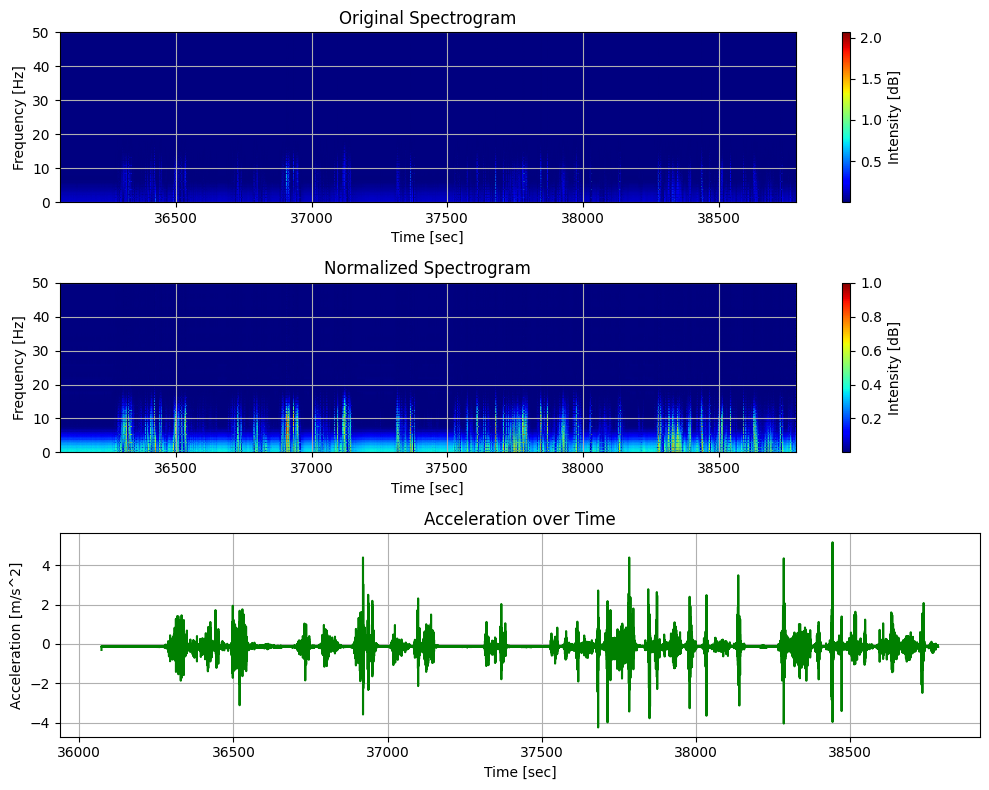

In [2]:
(
    data_f20_10_px_ra_mat,
    signal_acc_mat,
    time_column_mat,
    df_mat,
) = preprocess_mat_data(
    data_path=mat_px_ra,
    acel_to_process=APPCFG.acceleration_to_analyze,
    time_col_name="timestamp_s",
)


# Apply STFT
(
    frequencies_acc,
    times_acc,
    magnitude_spectrogram_acc,
    X_prime_acc,
    total_time_acc,
) = short_term_fourier_transform_stft(
    signal=signal_acc_mat,
    sampling_frequency_stft=APPCFG.sampling_frequency_stft_prepared,
    window_length=APPCFG.window_length,
    overlap=APPCFG.overlap,
    gamma=APPCFG.gamma,
    time_column=time_column_mat,
    nfft=APPCFG.nfft_prepared,
)


plot_stft_results(
    frequencies_acc,
    times_acc,
    magnitude_spectrogram_acc,
    X_prime_acc,
    total_time_acc,
    signal_acc_mat,
)


In [3]:
print(f"Shape of STFT time array: {times_acc.shape}")
print(f"Full time range: {times_acc.min()} to {times_acc.max()}")
print(f"Number of time points: {len(times_acc)}")
print(f"Time range of original signal: {time_column_mat.min()} to {time_column_mat.max()}")

Shape of STFT time array: (135651,)
Full time range: 36072.0 to 38785.0
Number of time points: 135651
Time range of original signal: 36072.0 to 38784.99


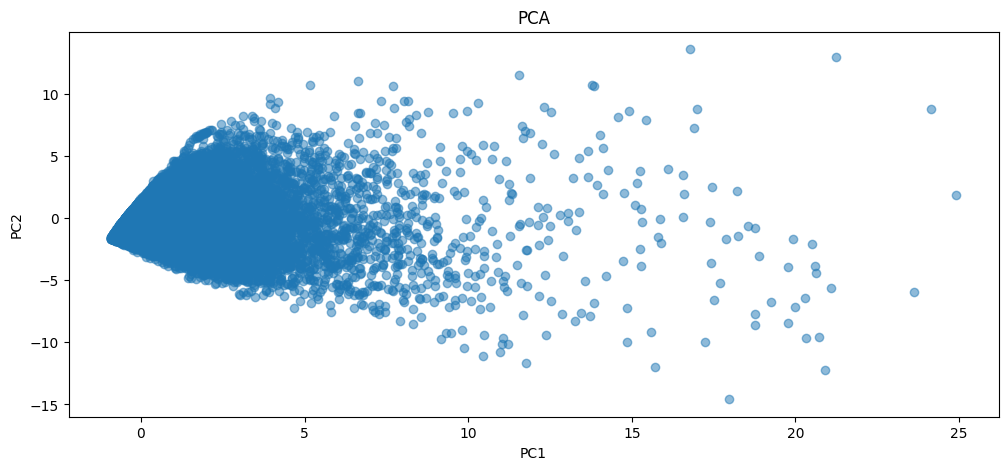

In [4]:

# Preprocess and reduce dimensionality
reduced_features_scaled = preprocess_and_reduce(magnitude_spectrogram_acc, n_components=10)

# Plot PCA and SVD results
plt.figure(figsize=(12, 5))
plt.scatter(reduced_features_scaled[:, 0], reduced_features_scaled[:, 1], alpha=0.5)
plt.title("PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


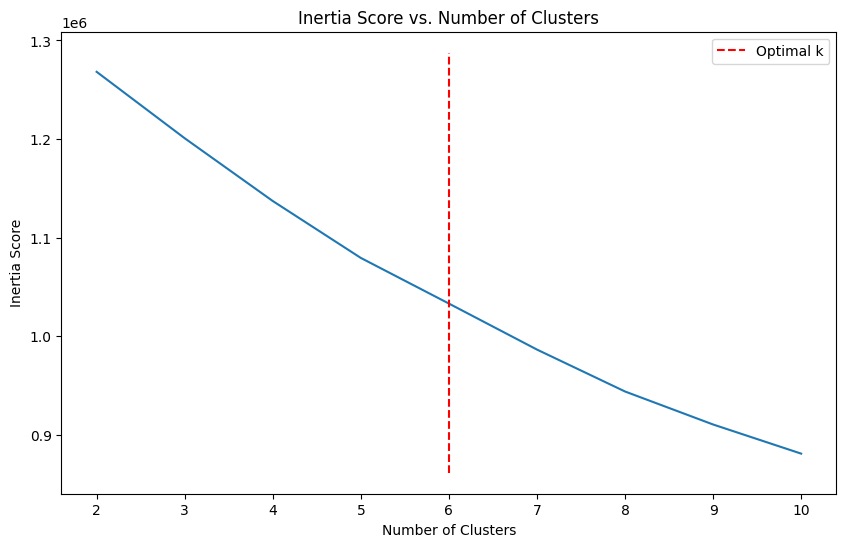

Optimal number of clusters: 6


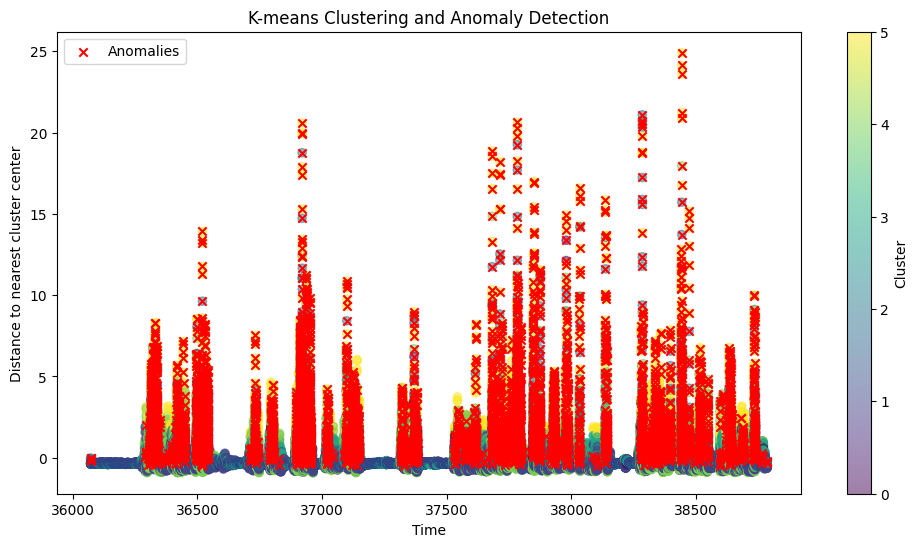

Anomalies saved to 'anomalies_kmeans.csv'


In [5]:
# Find optimal number of clusters
max_k = 10
optimal_k = find_optimal_clusters(reduced_features_scaled, max_k)
print(f"Optimal number of clusters: {optimal_k}")

# Apply K-means clustering
mbkmeans, labels = apply_MiniBatchKMeans(reduced_features_scaled, optimal_k)

# Identify anomalies using K-means
anomalies_kmeans = identify_anomalies_kmeans(reduced_features_scaled, mbkmeans)

# Plot clustering results with anomalies
plot_clusters_and_anomalies_kmeans(times_acc, reduced_features_scaled, labels, anomalies_kmeans)

# Save K-means anomalies to CSV
save_anomalies_to_csv(anomalies_kmeans, times_acc, frequencies_acc, "anomalies_kmeans.csv")

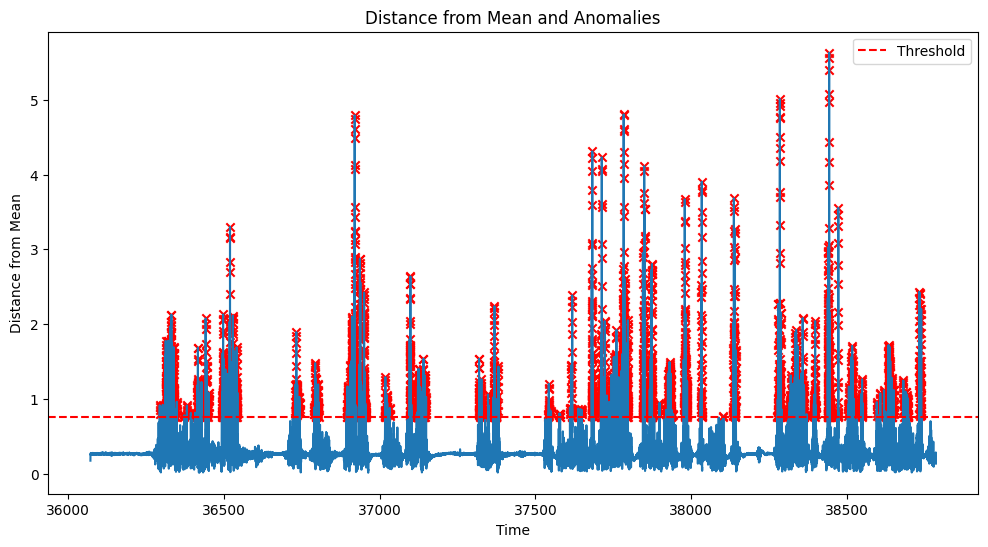

Anomalies saved to 'anomalies_distance.csv'


In [6]:
# Identify anomalies using distance from mean
distances_from_mean, threshold, anomalies_distance = identify_anomalies_distance(magnitude_spectrogram_acc)

# Plot anomalies detected by distance from mean
plot_clusters_and_anomalies_distance(times_acc, anomalies_distance, distances_from_mean, threshold)
# Save distance-based anomalies to CSV
save_anomalies_to_csv(anomalies_distance, times_acc, frequencies_acc, "anomalies_distance.csv")

In [7]:
# Print summary
print(f"Total data points: {len(reduced_features_scaled)}")
print(f"Anomalies detected by K-means: {np.sum(anomalies_kmeans)}, Percentage: {np.round(np.sum(anomalies_kmeans)/len(times_acc)*100, 2)}%")
print(f"K-means time range: {times_acc[np.where(anomalies_kmeans)[0]].min()} to {times_acc[np.where(anomalies_kmeans)[0]].max()}")
print(f"Anomalies detected by distance from mean: {np.sum(anomalies_distance)}, Percentage: {np.round(np.sum(anomalies_distance)/len(times_acc)*100, 2)}%")
print(f"Distance from mean time range: {times_acc[np.where(anomalies_distance)[0]].min()} to {times_acc[np.where(anomalies_distance)[0]].max()}")

Total data points: 135651
Anomalies detected by K-means: 6783, Percentage: 5.0%
K-means time range: 36072.0 to 38785.0
Anomalies detected by distance from mean: 4738, Percentage: 3.49%
Distance from mean time range: 36294.4 to 38738.12
